In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std),
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomCrop(32, 4)])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

train, val = torch.utils.data.random_split(trainset, [48000, 2000])
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, in_channels * 2, 3, stride=1, padding=1, bias=False)
    self.norm1 = nn.BatchNorm2d(in_channels * 2)
    self.conv2 = nn.Conv2d(in_channels * 2, in_channels * 2, 3, stride=1, padding=1, bias=False)
    self.norm2 = nn.BatchNorm2d(in_channels * 2)
    self.conv3 = nn.Conv2d(in_channels * 2, in_channels, 3, stride=1, padding=1, bias=False)
    self.norm3 = nn.BatchNorm2d(in_channels)

  def forward(self, x):
    residual = x
    x = F.relu(self.norm1(self.conv1(x)))
    x = F.relu(self.norm2(self.conv2(x)))
    x = self.norm3(self.conv3(x))
    return F.relu(residual + x)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1) # 16x16
        self.norm1 = nn.BatchNorm2d(64)

        self.res2 = ResidualBlock(64)
        self.res2 = ResidualBlock(64)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # 8x8
        self.norm2 = nn.BatchNorm2d(128)

        self.res3 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # 4x4
        self.norm3 = nn.BatchNorm2d(256)

        self.res4 = ResidualBlock(256)
        self.res4 = ResidualBlock(256)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # 2x2
        self.norm4 = nn.BatchNorm2d(512)

        self.res5 = ResidualBlock(512)
        self.res5 = ResidualBlock(512)
        self.conv5 = nn.Conv2d(512, 1024, 3, stride=2, padding=1) # 1x1
        self.norm5 = nn.BatchNorm2d(1024)

        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1((x))))
        x = F.relu(self.norm2(self.conv2(self.res2(x))))
        x = F.relu(self.norm3(self.conv3(self.res3(x))))
        x = F.relu(self.norm4(self.conv4(self.res4(x))))
        x = F.relu(self.norm5(self.conv5(self.res5(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device);

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
train_losses, val_losses = [], []
lowest_val_loss = np.inf
PATH = './cifar_net.pth'

In [8]:
for epoch in range(32):
    epoch_train_losses, epoch_val_losses = [], []
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        pred = net(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.detach().cpu().numpy())
    
    correct = 0
    total = 0
    for x, y in valloader:
        x, y = x.to(device), y.to(device)
        pred = net(x)
        loss = criterion(pred, y)
        epoch_val_losses.append(loss.detach().cpu().numpy())

        _, predicted = torch.max(pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    avg_train_loss = np.mean(epoch_train_losses)
    avg_val_loss = np.mean(epoch_val_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f'Epoch: {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct // total} %')
    if avg_val_loss < lowest_val_loss:
      lowest_val_loss = avg_val_loss
      torch.save(net.state_dict(), PATH)
            
print('Finished Training')

Epoch: 0, Training Loss: 1.5322623252868652, Validation Loss: 1.3236362934112549, Validation Accuracy: 51 %
Epoch: 1, Training Loss: 1.1290141344070435, Validation Loss: 1.0504295825958252, Validation Accuracy: 62 %
Epoch: 2, Training Loss: 0.9339710474014282, Validation Loss: 0.8433657884597778, Validation Accuracy: 70 %
Epoch: 3, Training Loss: 0.8086270093917847, Validation Loss: 0.7683345079421997, Validation Accuracy: 73 %
Epoch: 4, Training Loss: 0.7084589600563049, Validation Loss: 0.7253309488296509, Validation Accuracy: 74 %
Epoch: 5, Training Loss: 0.636045515537262, Validation Loss: 0.6260989904403687, Validation Accuracy: 77 %
Epoch: 6, Training Loss: 0.5777758359909058, Validation Loss: 0.6093688607215881, Validation Accuracy: 78 %
Epoch: 7, Training Loss: 0.5324903130531311, Validation Loss: 0.5672436952590942, Validation Accuracy: 80 %
Epoch: 8, Training Loss: 0.485988050699234, Validation Loss: 0.5406346321105957, Validation Accuracy: 82 %
Epoch: 9, Training Loss: 0.456

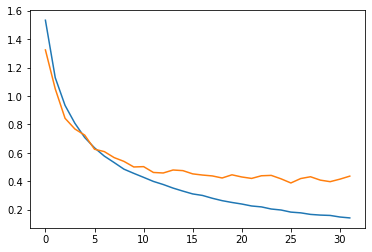

In [9]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show();

In [10]:
net = Net()
net.load_state_dict(torch.load('./cifar_net.pth'))
net.to(device);

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 88 %
